
#Create a Rnn for time series



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, LSTM
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns

Using TensorFlow backend.


In [0]:
#Get access to google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
names = ['Shay', 'Ido']
activities = ['drinking', 'eating', 'on_computer', 'on_phone']
data_map = {'training_map': {}, 'validation_map': {}, 'testing_map': {}}

In [0]:
#Get csv files from the drive
for name in names:
  for activity in activities:
    data_map['training_map'][f'{name}_{activity}'] = list(map(lambda i: pd.read_csv(
        f'drive/My Drive/Shared folder University/files_project/{name}/{name}_is_{activity}/{i}/{name}_is_{activity}{i}.csv'), range(1,7)))
       
for name in names:
  for activity in activities:
    data_map['validation_map'][f'{name}_{activity}'] = list(map(lambda i: pd.read_csv(
        f'drive/My Drive/Shared folder University/files_project/{name}/{name}_is_{activity}/{i}/{name}_is_{activity}{i}.csv'), range(7,9)))
       
for name in names:
  for activity in activities:
    data_map['testing_map'][f'{name}_{activity}'] = list(map(lambda i: pd.read_csv(
        f'drive/My Drive/Shared folder University/files_project/{name}/{name}_is_{activity}/{i}/{name}_is_{activity}{i}.csv'), range(9,11)))
    
print('training_map containas: {}'.format(len(data_map['training_map']['Shay_drinking'])))
print('validation_map containas: {}'.format(len(data_map['validation_map']['Shay_drinking'])))
print('testing_map containas: {}'.format(len(data_map['testing_map']['Shay_drinking'])))

training_map containas: 6
validation_map containas: 2
testing_map containas: 2


In [0]:
#dealing with NA
for data_division_map in data_map:
  for name_activity in data_map[data_division_map]:
    for df in data_map[data_division_map][name_activity]:
      number = round(float(df["Heart_Rate"].mean()))
      df.fillna(float(number), inplace=True)

In [0]:
#concat all dataframes
for data_division_map in data_map:
  for name_activity in data_map[data_division_map]:
    data_map[data_division_map][name_activity] = pd.concat(data_map[data_division_map][name_activity])

In [0]:
for data_division_map in data_map:  
  data_map[data_division_map] = pd.concat(list(data_map[data_division_map].values()))

In [0]:
training_set = data_map['training_map']
validation_set = data_map['validation_map']
testing_set = data_map['testing_map']

In [0]:
print('Training size is: {}'.format(len(training_set)))
print(training_set.isnull().sum())

print('validation size is: {}'.format(len(validation_set)))
print(validation_set.isnull().sum())

print('testing size is: {}'.format(len(testing_set)))
print(testing_set.isnull().sum())

Training size is: 29347
ID            0
Time          0
Acce_X        0
Acce_Y        0
Acce_Z        0
Gyro_X        0
Gyro_Y        0
Gyro_Z        0
Gravity_X     0
Gravity_Y     0
Gravity_Z     0
Roll          0
Pitch         0
Yaw           0
Heart_Rate    0
Activity      0
dtype: int64
validation size is: 9805
ID            0
Time          0
Acce_X        0
Acce_Y        0
Acce_Z        0
Gyro_X        0
Gyro_Y        0
Gyro_Z        0
Gravity_X     0
Gravity_Y     0
Gravity_Z     0
Roll          0
Pitch         0
Yaw           0
Heart_Rate    0
Activity      0
dtype: int64
testing size is: 9744
ID            0
Time          0
Acce_X        0
Acce_Y        0
Acce_Z        0
Gyro_X        0
Gyro_Y        0
Gyro_Z        0
Gravity_X     0
Gravity_Y     0
Gravity_Z     0
Roll          0
Pitch         0
Yaw           0
Heart_Rate    0
Activity      0
dtype: int64


In [0]:
training_set.to_csv('drive/My Drive/Shared folder University/files_project/train_set.csv',index=False)

In [0]:
training_set.head()

,ID,Time,Acce_X,Acce_Y,Acce_Z,Gyro_X,Gyro_Y,Gyro_Z,Gravity_X,Gravity_Y,Gravity_Z,Roll,Pitch,Yaw,Heart_Rate,Activity
0,1,0:07:30,0.021259,0.017636,0.016251,-0.207135,0.024490,-0.084649,-0.046664,-0.588025,-0.807496,-0.057725,0.628615,0.033968,57.0,Drinking
1,1,0:07:30,0.045287,0.098442,0.100549,-0.158365,0.152945,-0.108134,-0.027709,-0.576454,-0.816659,-0.033916,0.614383,0.008766,57.0,Drinking
2,1,0:07:30,-0.018428,0.029719,0.033534,-0.516809,0.176393,-0.044717,0.010265,-0.535853,-0.844249,0.012158,0.565518,-0.017456,57.0,Drinking
3,1,0:07:30,-0.030020,0.097264,-0.011148,-0.373862,0.134326,0.054780,0.006429,-0.512090,-0.858908,0.007485,0.537617,-0.006353,57.0,Drinking
4,1,0:07:30,0.077300,0.015769,0.029338,-0.166969,-0.073954,0.025240,0.009064,-0.483909,-0.875071,0.010358,0.505116,-0.004498,57.0,Drinking


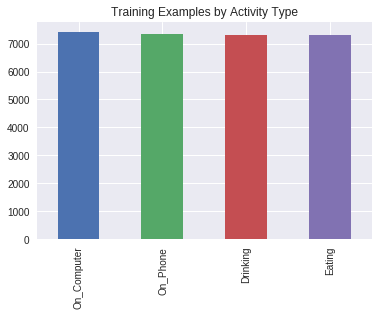

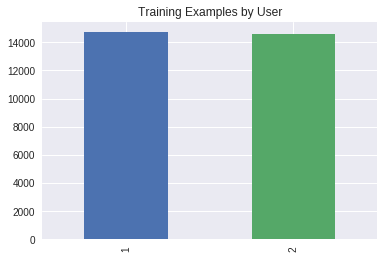

In [0]:
# Show how many training examples exist for each of the six activities
training_set['Activity'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
plt.show()

# Better understand how the recordings are spread across the different
# users who participated in the study
training_set['ID'].value_counts().plot(kind='bar', title='Training Examples by User')
plt.show()

In [0]:
def plot_activity(activity, data):
    fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=7,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['Time'], data['Acce_X'], 'Acc-X-Axis')
    plot_axis(ax1, data['Time'], data['Acce_Y'], 'Acc-Y-Axis')
    plot_axis(ax2, data['Time'], data['Acce_Z'], 'Acc-Z-Axis')
    plot_axis(ax3, data['Time'], data['Gyro_X'], 'Gyro-X-Axis')
    plot_axis(ax4, data['Time'], data['Gyro_Y'], 'Gyro-Y-Axis')
    plot_axis(ax5, data['Time'], data['Gyro_Z'], 'Gyro-Z-Axis')
    plot_axis(ax6, data['Time'], data['Heart_Rate'], 'Heart Rate')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [0]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

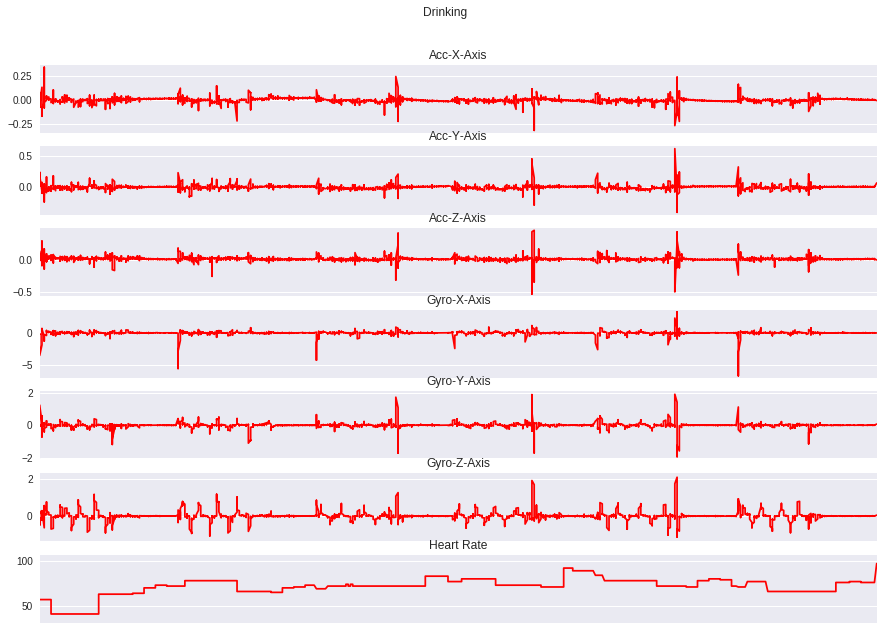

In [0]:
subset = training_set[:3647]
plot_activity('Drinking', subset)

In [0]:
def create_activity_encoded(data_set, le_set):
    # Define column name of the label vector
    LABEL = 'ActivityEncoded'
    # Add a new column to the existing DataFrame with the encoded values
    data_set[LABEL] = le_set.fit_transform(data_set['Activity'].values.ravel())
    data_set.drop('Activity', axis=1,inplace = True)

    '''
    #You need this to get back the real label
    analyze_data[LABEL] = le_set.inverse_transform(analyze_data[LABEL].values.ravel())
    print(analyze_data)
    '''

In [0]:
# Transform the labels from String to Integer via LabelEncoder
le_training_activity = preprocessing.LabelEncoder()
le_validation_activity = preprocessing.LabelEncoder()
le_testing_activity = preprocessing.LabelEncoder()


create_activity_encoded(training_set,le_training_activity)
create_activity_encoded(validation_set,le_validation_activity)
create_activity_encoded(testing_set,le_testing_activity)

In [0]:
#take a df to do things and see the outecomes
check_training_data = training_set
check_validation_data = validation_set
check_testing_data = testing_set

In [0]:
def create_time_encoded(data_set, le_set):
    # Add a new column to the existing DataFrame with the encoded values
    data_set['Time_Stamp'] = le_set.fit_transform(data_set['Time'].values.ravel())
    data_set = data_set.drop('Time', axis=1, inplace = True)

    '''
    #You need this to get back the real label
    data_set[LABEL] = le_set.inverse_transform(data_set[LABEL].values.ravel())
    print(data_set)
    '''

In [0]:
# Transform the time from String to Integer via LabelEncoder
#le_training_time = preprocessing.LabelEncoder()
#le_validation_time = preprocessing.LabelEncoder()
#le_testing_time = preprocessing.LabelEncoder()
le_time = preprocessing.LabelEncoder()

create_time_encoded(training_set,le_time)
create_time_encoded(validation_set,le_time)
create_time_encoded(testing_set,le_time)

#Normalize And Standardize Time Series Data

we rescaling the data from original so the vaules are within range of 0 to 1

y  = (x - mean) / std

y = ( x - min) / (max - min)

In [0]:
for column in training_set.columns[1:14]:
    print(column)

Acce_X
Acce_Y
Acce_Z
Gyro_X
Gyro_Y
Gyro_Z
Gravity_X
Gravity_Y
Gravity_Z
Roll
Pitch
Yaw
Heart_Rate


In [0]:
#go over the colunms in pd and do normalization and standardiztion
for column in training_set.columns[1:14]:
  #training_set[column] = (training_set[column] - np.mean(training_set[column]))/(np.std(training_set[column]))
  training_set[column] = (training_set[column] - min(training_set[column])) / (max(training_set[column]) - min(training_set[column]))
  #3 digits in decimal
  training_set = round(training_set,3)  

In [0]:
#go over the colunms in pd and do normalization and standardiztion
for column in validation_set.columns[1:14]:
  #validation_set[column] = (validation_set[column] - np.mean(validation_set[column]))/(np.std(validation_set[column]))
  validation_set[column] = (validation_set[column] - min(validation_set[column])) / (max(validation_set[column]) - min(validation_set[column]))
  #3 digits in decimal
  validation_set = round(validation_set,3)

In [0]:
#go over the colunms in pd and do normalization and standardiztion
for column in testing_set.columns[1:14]:
  #testing_set[column] = (testing_set[column] - np.mean(testing_set[column]))/(np.std(testing_set[column]))
  testing_set[column] = (testing_set[column] - min(testing_set[column])) / (max(testing_set[column]) - min(testing_set[column]))
  #3 digits in decimal
  testing_set = round(testing_set,3)

This function will create segments and for each segment will attaced the most significant label 

the size of the segment is SEGMANT_SIZE
the size of which we moving from sgement to segment is STEP_DISTANCE



In [0]:
def create_segments_and_labels(df, segmant_size, step, label_name):
    # sensors as features
    N_FEATURES = 13
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the segmant_size in order to have no overlap between segments)
    # step = segmant_size
    segments = []
    labels = []
    for i in range(0, len(df) - segmant_size, step):
      append_segments = list(map(lambda label: df[label].values[i: i + segmant_size], df.columns[1:14]))
      # Retrieve the most often used label in this segment
      label = stats.mode(df[label_name][i: i + segmant_size])[0][0]
      segments.append(append_segments)
      labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, segmant_size, N_FEATURES)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [0]:
SEGMANT_SIZE = 20
STEP_DISTANCE = 5
LABEL = 'ActivityEncoded'

x_train, y_train = create_segments_and_labels(training_set, SEGMANT_SIZE, STEP_DISTANCE, LABEL)
x_validation, y_validation =  create_segments_and_labels(validation_set, SEGMANT_SIZE, STEP_DISTANCE, LABEL)

In [0]:
print(len(training_set))
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

29347
x_train shape:  (5866, 20, 13)
5866 training samples
y_train shape:  (5866,)


In [0]:
print(len(validation_set))
print('x_validation shape: ', x_validation.shape)
print(x_validation.shape[0], 'training samples')
print('y_validation shape: ', y_validation.shape)

9805
x_validation shape:  (1957, 20, 13)
1957 training samples
y_validation shape:  (1957,)


In [0]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le_training_activity.classes_.size
print(list(le_training_activity.classes_))

['Drinking', 'Eating', 'On_Computer', 'On_Phone']


In [0]:
# Set input & output dimensions
num_time_periods_validation, num_sensors_validation = x_validation.shape[1], x_validation.shape[2]

In [0]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (5866, 260)
input_shape: 260


In [0]:
input_shape_validation = (num_time_periods_validation*num_sensors_validation)
x_validation = x_validation.reshape(x_validation.shape[0], input_shape_validation)
print('x_validation shape:', x_validation.shape)
print('input_shape_validation:', input_shape_validation)

x_validation shape: (1957, 260)
input_shape_validation: 260


In [0]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_validation = x_validation.astype('float32')
y_validation = y_validation.astype('float32')

In [0]:
y_train_hot_encoding = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot_encoding.shape)

New y_train shape:  (5866, 4)


In [0]:
y_validation_hot_encoding = np_utils.to_categorical(y_validation, num_classes)
print('New y_validation shape: ', y_validation_hot_encoding.shape)

New y_validation shape:  (1957, 4)


In [0]:
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((SEGMANT_SIZE, 13), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 20, 13)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 20, 100)           1400      
_________________________________________________________________
dense_2 (Dense)              (None, 20, 100)           10100     
_________________________________________________________________
dense_3 (Dense)              (None, 20, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 8004      
Total params: 29,604
Trainable params: 29,604
Non-trainable params: 0


In [0]:
'''
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]
'''

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 20
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train, y_train_hot_encoding, validation_data=(x_validation, y_validation_hot_encoding), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 5866 samples, validate on 1957 samples
Epoch 1/50
5866/5866 [==============================] - 3s 479us/step - loss: 0.9710 - acc: 0.5892 - val_loss: 0.9603 - val_acc: 0.6490
Epoch 2/50
5866/5866 [==============================] - 2s 306us/step - loss: 0.7091 - acc: 0.7102 - val_loss: 0.9819 - val_acc: 0.6346
Epoch 3/50
5866/5866 [==============================] - 2s 306us/step - loss: 0.6291 - acc: 0.7492 - val_loss: 1.1653 - val_acc: 0.6106
Epoch 4/50
5866/5866 [==============================] - 2s 302us/step - loss: 0.5734 - acc: 0.7685 - val_loss: 1.4779 - val_acc: 0.5457
Epoch 5/50
5866/5866 [==============================] - 2s 303us/step - loss: 0.5458 - acc: 0.7881 - val_loss: 1.5355 - val_acc: 0.5611
Epoch 6/50
5866/5866 [==============================] - 2s 302us/step - loss: 0.5125 - acc: 0.8007 - val_loss: 2.0672 - val_acc: 0.4149
Epoch 7/50
5866/5866 [==============================] - 2s 304us/step - loss: 0.4973 - a

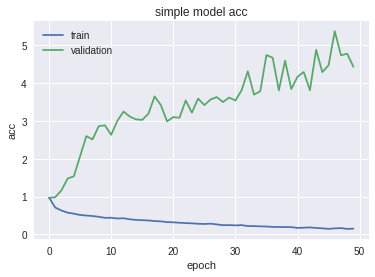

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('simple model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, valX, valy):
  verbose, epochs, batch_size = 1, 20, 50
  n_timesteps, n_features, n_outputs = 20, 13, 4
  model = Sequential()  
  model.add(Reshape((SEGMANT_SIZE, 13), input_shape=(260,)))
  model.add(LSTM(100, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  history = model.fit(trainX, trainy, validation_data=(valX, valy), epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model, history
   

In [0]:
model, history = evaluate_model(x_train, y_train_hot_encoding,x_validation, y_validation_hot_encoding)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 5866 samples, validate on 1957 samples
Epoch 1/20
5866/5866 [==============================] - 7s 1ms/step - loss: 1.3306 - acc: 0.3144 - val_loss: 1.4772 - val_acc: 0.3229
Epoch 2/20
5866/5866 [==============================] - 6s 1ms/step - loss: 1.1115 - acc: 0.4944 - val_loss: 0.9977 - val_acc: 0.5314
Epoch 3/20
5866/5866 [==============================] - 6s 1ms/step - loss: 0.9556 - acc: 0.5863 - val_loss: 0.9239 - val_acc: 0.5846
Epoch 4/20
5866/5866 [==============================] - 6s 1ms/step - loss: 0.8854 - acc: 0.6234 - val_loss: 0.8651 - val_acc: 0.6265
Epoch 5/20
5866/5866 [==============================] - 6s 1ms/step - loss: 0.8356 - acc: 0.6527 - val_loss: 0.9411 - val_acc: 0.5958
Epoch 6/20
5866/5866 [==============================] - 6s 1ms/step - loss: 0.8131 - acc: 0.6686 - val_loss: 0.9264 - val_acc: 0.6244
Epoch 7/20
5866/5866 [===========

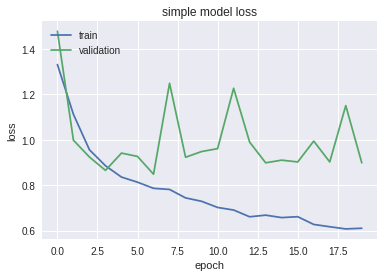

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('simple model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

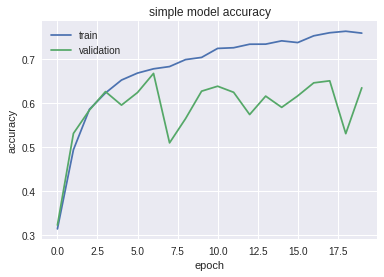

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('simple model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

work on test

In [0]:
x_test, y_test = create_segments_and_labels(testing_set, SEGMANT_SIZE, STEP_DISTANCE, LABEL)

In [0]:
print(len(testing_set))
print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'training samples')
print('y_test shape: ', y_test.shape)

9744
x_test shape:  (1945, 20, 13)
1945 training samples
y_test shape:  (1945,)


In [0]:
# Set input & output dimensions
num_time_periods_test, num_sensors_test = x_test.shape[1], x_test.shape[2]

In [0]:
input_shape_test = (num_time_periods_test*num_sensors_test)
x_test = x_test.reshape(x_test.shape[0], input_shape_test)
print('x_test shape:', x_test.shape)
print('input_shape_test:', input_shape_test)


x_test shape: (1945, 260)
input_shape_test: 260


In [0]:
x_test = x_validation.astype('float32')
#y_test = y_validation.astype('float32')

In [0]:
'''
y_test_hot_encoding = np_utils.to_categorical(y_test, num_classes)
print('New y_test shape: ', y_test_hot_encoding.shape)
'''


"\ny_test_hot_encoding = np_utils.to_categorical(y_test, num_classes)\nprint('New y_test shape: ', y_test_hot_encoding.shape)\n"

In [0]:
preds = model.predict(x_test[:1945])
pred_cat = np.argmax(preds,axis=1)
print('')
print()

In [0]:
len(y_test)

1945

model accuracy on traning set is: 75.94613000024027%
model accuracy on validation set is: 63.515585039989276%
model accuracy on test set is: 63.75321336760925%


Text(0.5, 1.0, 'simple model classification results on test set')

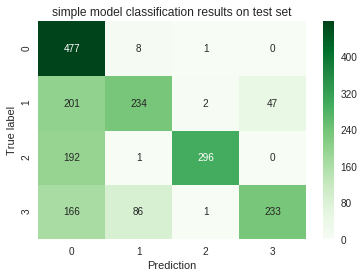

In [0]:
print('model accuracy on traning set is: {}%'.format(history.history['acc'][19]*100))
print('model accuracy on validation set is: {}%'.format(history.history['val_acc'][19]*100))
print('model accuracy on test set is: {}%'.format(accuracy_score(y_test,pred_cat)*100))
sns.heatmap(confusion_matrix(y_test,pred_cat),cmap='Greens',annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('simple model classification results on test set')